## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
!pip install pmdarima


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings 
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller # ADF test 
from statsmodels.tsa.seasonal import seasonal_decompose #For identifying trends and seasonality
from statsmodels.tsa.arima.model import ARIMA #ARIMA model
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt # Importing matplot library for ploting graph
from prophet import Prophet
from sklearn.model_selection import ParameterGrid # Grid search

Importing plotly failed. Interactive plots will not work.


## Loading the dataset

In [3]:
df = pd.read_csv("BTC-Daily.csv", parse_dates=['date'], index_col='date')

# Sort the data by date
df = df.sort_index()

print(df.head())

                  unix   symbol    open    high     low   close  Volume BTC  \
date                                                                          
2014-11-28  1417132800  BTC/USD  363.59  381.34  360.57  376.28  3220878.18   
2014-11-29  1417219200  BTC/USD  376.42  386.60  372.25  376.72  2746157.05   
2014-11-30  1417305600  BTC/USD  376.57  381.99  373.32  373.34  1145566.61   
2014-12-01  1417392000  BTC/USD  376.40  382.31  373.03  378.39  2520662.37   
2014-12-02  1417478400  BTC/USD  378.39  382.86  375.23  379.25  2593576.46   

            Volume USD  
date                    
2014-11-28     8617.15  
2014-11-29     7245.19  
2014-11-30     3046.33  
2014-12-01     6660.56  
2014-12-02     6832.53  


In [4]:
df

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2014-11-28,1417132800,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
2022-02-26,1645833600,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2022-02-27,1645920000,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07


In [5]:
df = df[['close']] #Taking only closing price data to forecast the price

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2651 entries, 2014-11-28 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2651 non-null   float64
dtypes: float64(1)
memory usage: 41.4 KB


## Finding missing values

In [7]:
print(df.isnull().sum())  # Check for missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

close    0
dtype: int64


## Visualizing bitcoin prices

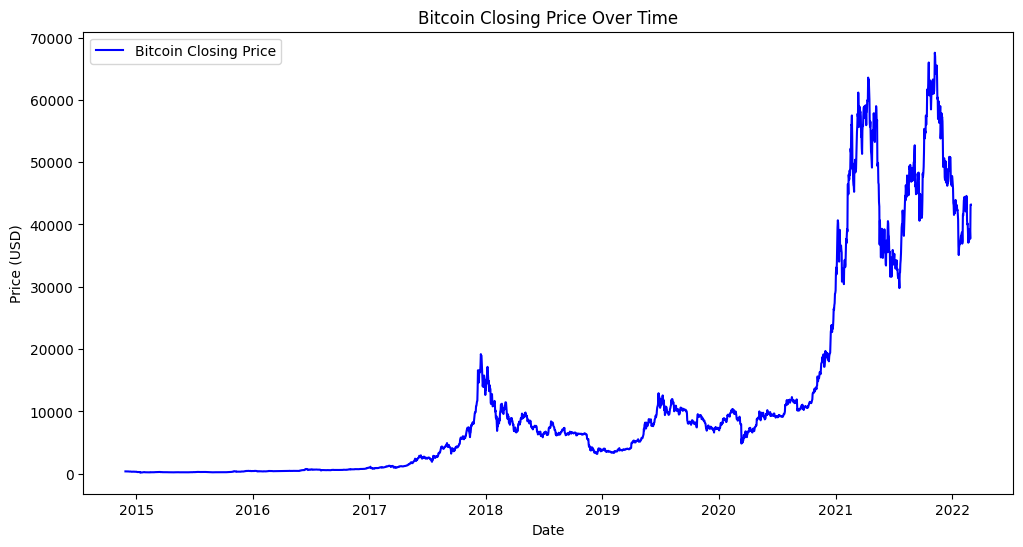

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Bitcoin Closing Price', color='blue')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Trend analysis

## Moving Averages (Trend Detection)

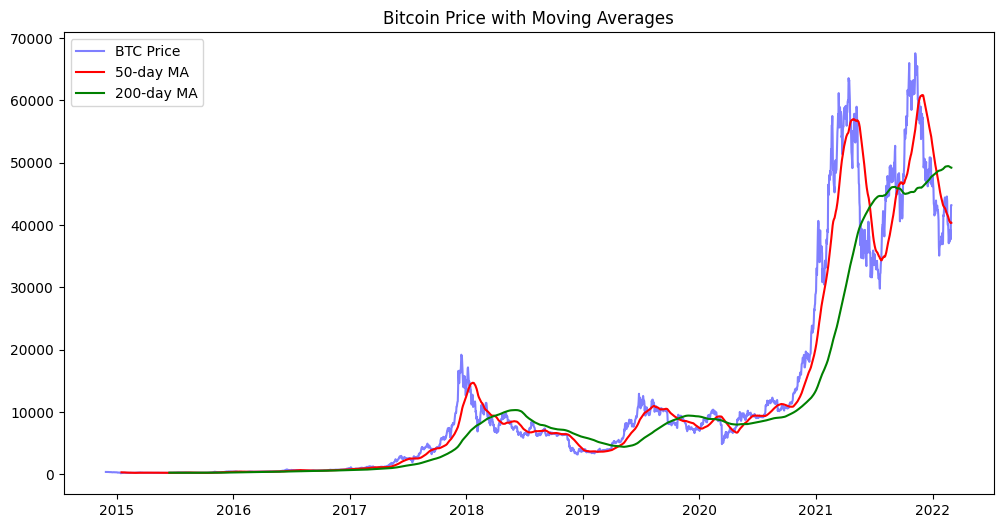

In [9]:
df['SMA_50'] = df['close'].rolling(window=50).mean()  # 50-day moving average
df['SMA_200'] = df['close'].rolling(window=200).mean()  # 200-day moving average

# Plotting the moving averages
plt.figure(figsize=(12,6))
plt.plot(df['close'], label="BTC Price", color='blue', alpha=0.5)
plt.plot(df['SMA_50'], label="50-day MA", color='red')
plt.plot(df['SMA_200'], label="200-day MA", color='green')
plt.title("Bitcoin Price with Moving Averages")
plt.legend()
plt.show()

## Checking for Stationarity (Augmented Dickey-Fuller (ADF) Test)

In [10]:
# Defining ADF Test to test the stationarity of the data
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary.")

In [11]:
# Running ADF Test on Bitcoin price data
adf_test(df['close'])

ADF Statistic: -0.9875841417510536
p-value: 0.7577657213555868
The data is NOT stationary.


## Condition for the ADF test

If p-value < 0.05 → The data is stationary.

If p-value > 0.05 → The data is non-stationary and needs transformation.

## Transforming Data for Stationarity

## Log Transformation

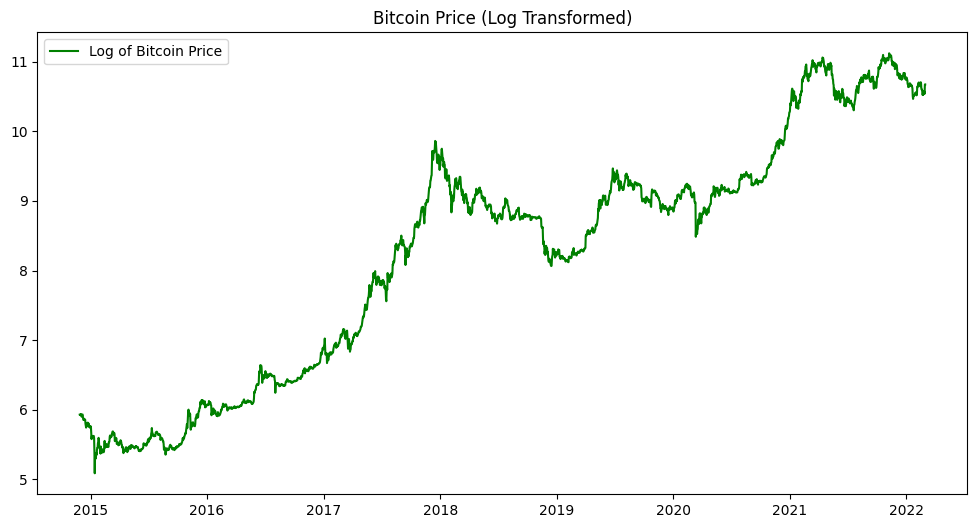

In [12]:
df['Log_close'] = np.log(df['close']) #Taking log of closing price

#Plotting the log of closing price 
plt.figure(figsize=(12, 6))
plt.plot(df['Log_close'], label="Log of Bitcoin Price", color="green")
plt.title("Bitcoin Price (Log Transformed)")
plt.legend()
plt.show()

In [13]:
adf_test(df['Log_close'])  # Check stationarity

ADF Statistic: -0.48117683076635753
p-value: 0.8956376654346662
The data is NOT stationary.


In [14]:
df['Log_First_Diff'] = df['Log_close'].diff()  # Differencing log data

adf_test(df['Log_First_Diff'].dropna())  # Pass the differenced series

ADF Statistic: -54.244228487257686
p-value: 0.0
The data is stationary.


## First Order Differencing

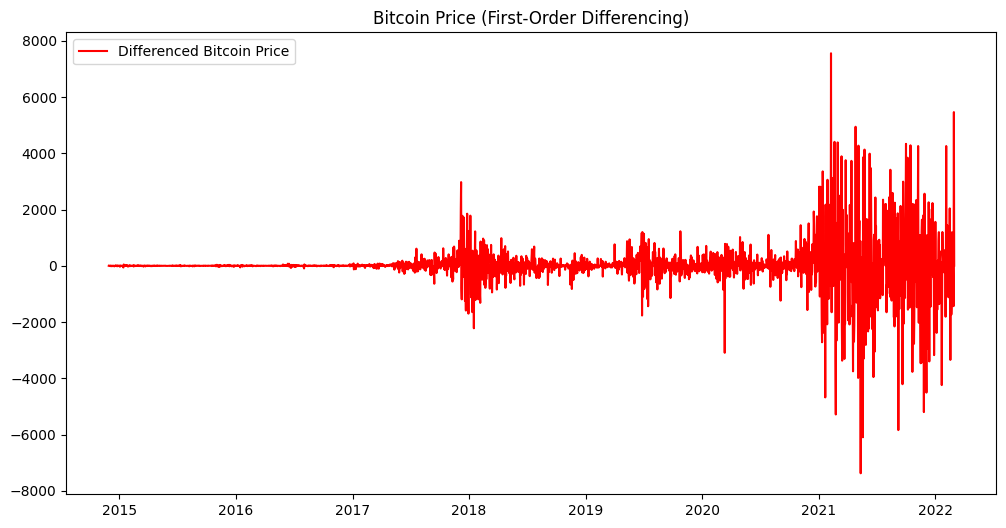

In [15]:
df['close_Diff'] = df['close'].diff() # Taking the difference of closing price

# Plotting the difference of closing price across the data 
plt.figure(figsize=(12, 6))
plt.plot(df['close_Diff'], label="Differenced Bitcoin Price", color="red")
plt.title("Bitcoin Price (First-Order Differencing)")
plt.legend()
plt.show()

In [16]:
# Check stationarity again
adf_test(df['close_Diff'].dropna())

ADF Statistic: -8.478502830382034
p-value: 1.4139138299595874e-13
The data is stationary.


## Seasonal Decomposition (Trend, Seasonality, Residuals)

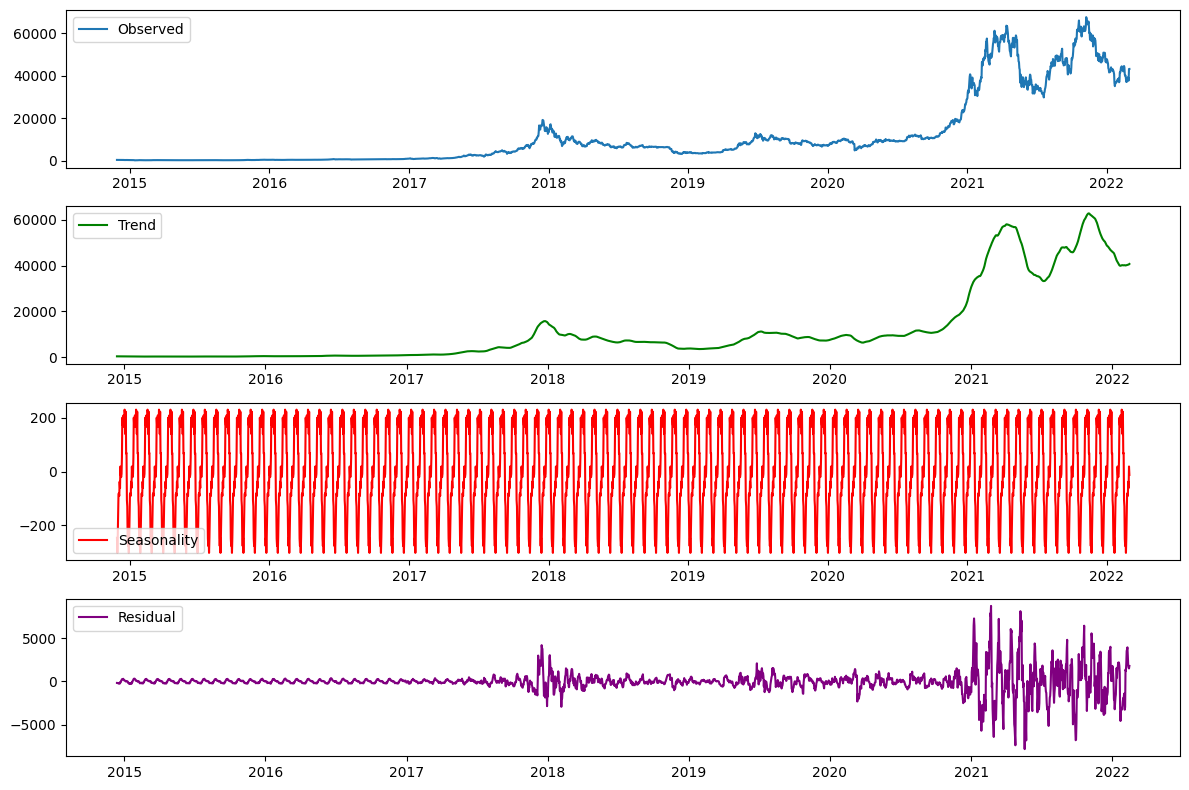

In [17]:
decomposed = seasonal_decompose(df['close'], model='additive', period=30)

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(decomposed.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposed.trend, label='Trend', color='green')
plt.legend()

plt.subplot(413)
plt.plot(decomposed.seasonal, label='Seasonality', color='red')
plt.legend()

plt.subplot(414)
plt.plot(decomposed.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()

## Train test split

In [18]:
train_size = int(len(df) * 0.8)  # 80% training data, 20% test data
train, test = df.iloc[:train_size], df.iloc[train_size:]

## ARIMA (AutoRegressive Integrated Moving Average)

In [19]:
# Auto ARIMA to find best (p,d,q)
auto_arima_model = pm.auto_arima(train['close'], seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA Order: {auto_arima_model.order}")
warnings.filterwarnings("ignore")
# Fit ARIMA model with optimal parameters
arima_model = ARIMA(train['close'], order=auto_arima_model.order)
arima_fit = arima_model.fit()

# Forecast for test set length
forecast = arima_fit.forecast(steps=len(test))
test = test.copy()  # Avoid SettingWithCopyWarning
test['Forecast_ARIMA'] = forecast.values  # Ensure alignment

# Evaluation
mae_arima = mean_absolute_error(test['close'], test['Forecast_ARIMA'])
rmse_arima = np.sqrt(mean_squared_error(test['close'], test['Forecast_ARIMA']))

print(f'ARIMA MAE: {mae_arima}')
print(f'ARIMA RMSE: {rmse_arima}')

Best ARIMA Order: (2, 1, 3)
ARIMA MAE: 29503.22236627769
ARIMA RMSE: 33059.59440366996


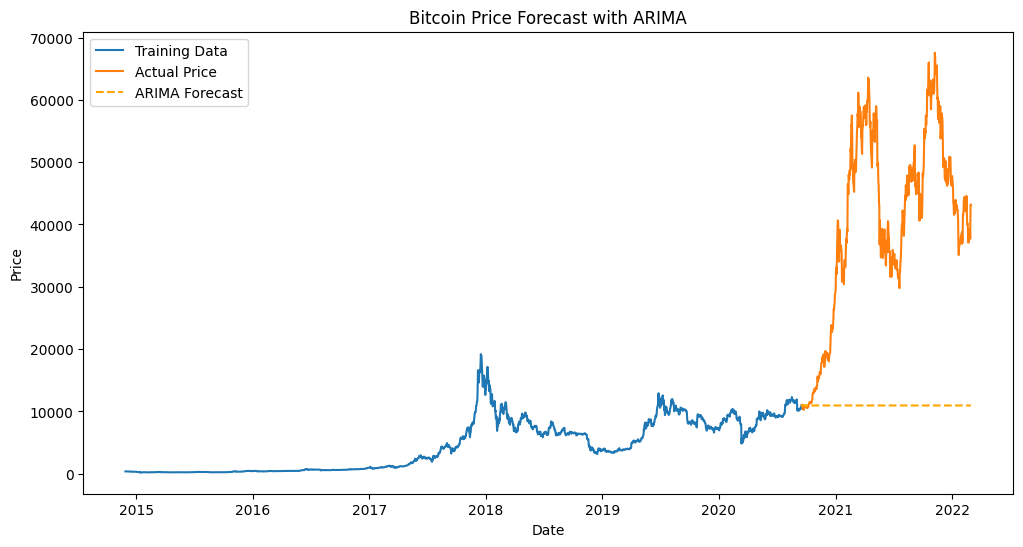

In [20]:
# PLotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(train['close'], label="Training Data")
plt.plot(test['close'], label="Actual Price")
plt.plot(test['Forecast_ARIMA'], label="ARIMA Forecast", linestyle="--", color="orange")
plt.title("Bitcoin Price Forecast with ARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Best ARIMA order: (1, 0, 0)
23281.825879481883
26685.417965000688


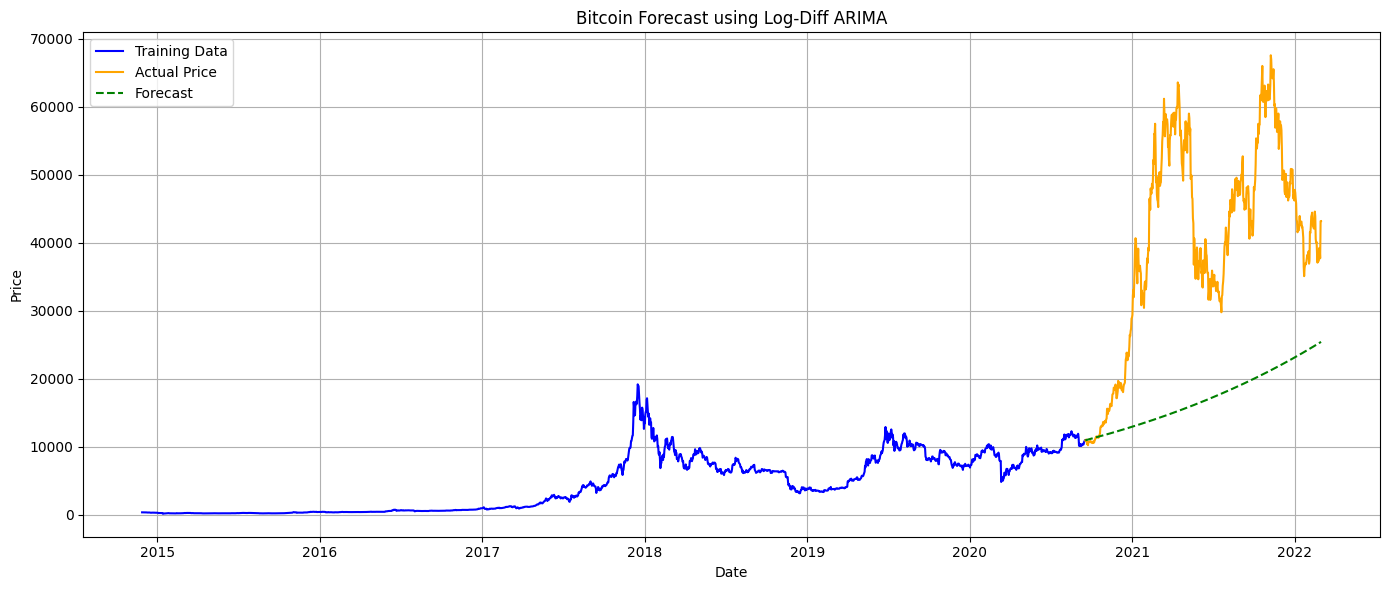

In [21]:
## Using log_diff to forecast the model
warnings.filterwarnings("ignore")

# Log-transform the training set
train['log_close'] = np.log(train['close'])

# Difference the log values to get log returns (stationary)
train['log_diff'] = train['log_close'].diff().dropna()

# Fit ARIMA on the differenced log values
train_diff = train['log_diff'].dropna()

# Using auto_arima to find best (p,d,q)
auto_model = pm.auto_arima(train_diff, seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA order: {auto_model.order}")

# Fit ARIMA
model = ARIMA(train_diff, order=auto_model.order)
model_fit = model.fit()

# Forecast log returns
n_test = len(test)
forecast_log_diff = model_fit.forecast(steps=n_test)

# Convert forecasted log returns back to log prices using cumulative sum
# Start from last known log price
last_log_price = train['log_close'].iloc[-1]
forecast_log_price = np.r_[last_log_price, forecast_log_diff].cumsum()

# Drop the first value (original last log) and convert to actual price
forecast_price = np.exp(forecast_log_price[1:])

# Adding forecast to test
test = test.copy()
test['Forecast_ARIMA'] = forecast_price

# Evaluation
mae_arima2 = mean_absolute_error(test['close'], test['Forecast_ARIMA'])
rmse_arima2 = np.sqrt(mean_squared_error(test['close'], test['Forecast_ARIMA']))
print(mae_arima2)
print(rmse_arima2)


# Plotting
plt.figure(figsize=(14,6))
plt.plot(train['close'], label="Training Data", color='blue')
plt.plot(test['close'], label="Actual Price", color='orange')
plt.plot(test['Forecast_ARIMA'], label="Forecast", color='green', linestyle='dashed')
plt.title("Bitcoin Forecast using Log-Diff ARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The above plot gives a visualization to compare the ARIMA model's forecast with actual Bitcoin prices. It plots the training data to provide historical context, the actual test set prices to serve as a benchmark, and the ARIMA forecasted values using a dashed line for distinction.

## Prophet model

In [22]:
# Prepare Data for Prophet
prophet_df = df[['close']].reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these column names

# Define and Train the Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Make Future Predictions
future = prophet_model.make_future_dataframe(periods=30)  # Predict next 30 days
forecast = prophet_model.predict(future)

# Evaluate Prophet Model
actual = df['close'].iloc[-30:].values  # Last 30 days of actual values
predicted = forecast['yhat'].iloc[-30:].values

mae_prophet = mean_absolute_error(actual, predicted)
rmse_prophet = np.sqrt(mean_squared_error(actual, predicted))

print(f'Prophet MAE: {mae_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')

10:36:09 - cmdstanpy - INFO - Chain [1] start processing
10:36:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 22066.86505117074
Prophet RMSE: 22239.667565916225


## Hyperparameter Tuning for prophet


In [23]:
## Using grid search for parameter tuning
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

best_rmse = float("inf")
best_params = None

for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'])
    model.fit(prophet_df)
    forecast = model.predict(future)
    predicted = forecast['yhat'].iloc[-30:].values

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print(f"Best Parameters: {best_params}")

10:36:10 - cmdstanpy - INFO - Chain [1] start processing
10:36:10 - cmdstanpy - INFO - Chain [1] done processing
10:36:11 - cmdstanpy - INFO - Chain [1] start processing
10:36:11 - cmdstanpy - INFO - Chain [1] done processing
10:36:12 - cmdstanpy - INFO - Chain [1] start processing
10:36:12 - cmdstanpy - INFO - Chain [1] done processing
10:36:13 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] done processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] done processing
10:36:15 - cmdstanpy - INFO - Chain [1] start processing
10:36:15 - cmdstanpy - INFO - Chain [1] done processing
10:36:16 - cmdstanpy - INFO - Chain [1] start processing
10:36:16 - cmdstanpy - INFO - Chain [1] done processing
10:36:17 - cmdstanpy - INFO - Chain [1] start processing
10:36:17 - cmdstanpy - INFO - Chain [1] done processing
10:36:18 - cmdstanpy - INFO - Chain [1] start processing
10:36:18 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


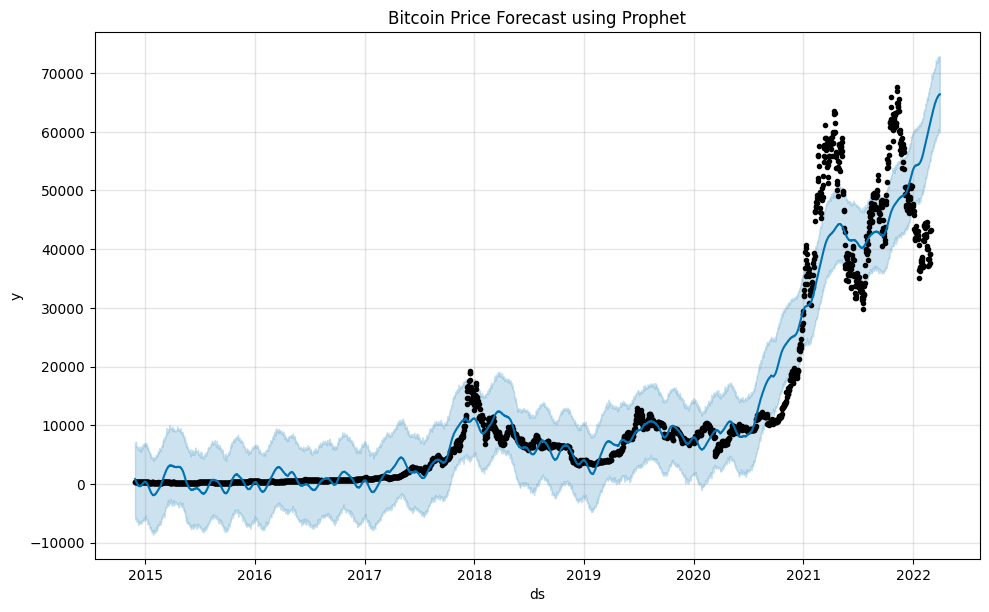

In [24]:
# Plot Forecast
prophet_model.plot(forecast)
plt.title("Bitcoin Price Forecast using Prophet")
plt.show()

The above plot gives a visualization of the Bitcoin price forecast using the Prophet model. It plots the predicted trend along with actual historical data, providing insights into future price movements. The chart also includes confidence intervals, which indicate the uncertainty in the predictions.  This visualization helps evaluate how well the Prophet model captures Bitcoin's price trends and provides a clear representation of potential future values.

## Model comparison

In [25]:
print(f"ARIMA:   MAE = {mae_arima}, RMSE = {rmse_arima}") # ARIMA model based on difference of closing price
print(f"ARIMA2: MAE = {mae_arima2}, RMSE = {rmse_arima2}") # ARIMA model based on difference of log of closing price
print(f"Prophet: MAE = {mae_prophet}, RMSE = {rmse_prophet}") # Prophet model

ARIMA:   MAE = 29503.22236627769, RMSE = 33059.59440366996
ARIMA2: MAE = 23281.825879481883, RMSE = 26685.417965000688
Prophet: MAE = 22066.86505117074, RMSE = 22239.667565916225
